In [484]:
import copy
import os
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from typing import Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchmetrics import Metric as LightningMetric


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, MultiHorizonMetric, MultiLoss, QuantileLoss
from pytorch_forecasting.models.base_model import BaseModelWithCovariates
from pytorch_forecasting.models.nn import LSTM, MultiEmbedding
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import (
    AddNorm,
    GateAddNorm,
    GatedLinearUnit,
    GatedResidualNetwork,
    InterpretableMultiHeadAttention,
    ScaledDotProductAttention,
    VariableSelectionNetwork,
)

In [485]:
data = pd.read_csv('volatility.csv')
data['date'] = pd.to_datetime(data['date'])
data["time_idx"] = np.busday_count(datetime(2000,1,3,0,0).date(), [d.date() for d in data['date']])
data['day_of_week'] = data['day_of_week'].astype(str)
data['day_of_month'] = data['day_of_month'].astype(str)
data['week_of_year'] = data['week_of_year'].astype(str)
data['month'] = data['month'].astype(str)

In [486]:
data[data['Symbol']=='.SPX']

,Unnamed: 0,Symbol,open_to_close,rk_parzen,close_price,open_time,rv5_ss,medrv,rsv,rsv_ss,...,days_from_start,day_of_week,day_of_month,week_of_year,month,year,categorical_id,log_vol,Region,time_idx
126766,2000-01-03 00:00:00+00:00,.SPX,-0.011602,0.000340,1454.24,83004.0,0.000141,0.000058,0.000096,0.000096,...,0,0,3,1,1,2000,.SPX,-8.868065,AMER,0
126767,2000-01-04 00:00:00+00:00,.SPX,-0.035102,0.000215,1399.02,83009.0,0.000224,0.000067,0.000180,0.000180,...,1,1,4,1,1,2000,.SPX,-8.403279,AMER,1
126768,2000-01-05 00:00:00+00:00,.SPX,0.004625,0.000163,1402.09,83012.0,0.000314,0.000142,0.000131,0.000131,...,2,2,5,1,1,2000,.SPX,-8.065219,AMER,2
126769,2000-01-06 00:00:00+00:00,.SPX,0.002991,0.000067,1403.06,83005.0,0.000131,0.000070,0.000056,0.000056,...,3,3,6,1,1,2000,.SPX,-8.941767,AMER,3
126770,2000-01-07 00:00:00+00:00,.SPX,0.026293,0.000215,1440.84,83000.0,0.000094,0.000049,0.000023,0.000023,...,4,4,7,1,1,2000,.SPX,-9.276248,AMER,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132119,2021-05-12 00:00:00+01:00,.SPX,-0.016432,0.000065,4063.23,93001.0,0.000073,0.000068,0.000049,0.000049,...,7800,2,12,19,5,2021,.SPX,-9.528455,AMER,5572
132120,2021-05-13 00:00:00+01:00,.SPX,0.009034,0.000118,4111.97,93001.0,0.000117,0.000083,0.000051,0.000051,...,7801,3,13,19,5,2021,.SPX,-9.050240,AMER,5573
132121,2021-05-14 00:00:00+01:00,.SPX,0.010610,0.000021,4173.63,93001.0,0.000038,0.000009,0.000011,0.000011,...,7802,4,14,19,5,2021,.SPX,-10.168405,AMER,5574
132122,2021-05-17 00:00:00+01:00,.SPX,-0.001476,0.000023,4163.77,93001.0,0.000044,0.000018,0.000021,0.000021,...,7805,0,17,20,5,2021,.SPX,-10.035961,AMER,5575


In [487]:
max_prediction_length = 5
max_encoder_length = 252
batch_size = 64
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    target="log_vol",
    time_idx="time_idx",
    group_ids=["Region", "Symbol"],
    min_encoder_length=249,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Region"],
    time_varying_known_categoricals=['day_of_week', 'day_of_month', 'week_of_year', 'month'],
    time_varying_known_reals=['time_idx', 'days_from_start'],
    time_varying_unknown_reals=['open_to_close'],
    target_normalizer=EncoderNormalizer(),
    add_relative_time_idx=True,
    add_target_scales=True,
    # add_encoder_length=True,
    allow_missings=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [488]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.6186046600341797

In [333]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.01,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.01,
    hidden_size=160,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=160,  # set to <= hidden_size
    output_size=3,  # 7 quantiles by default
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=5,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 2161.4k


In [334]:
torch.cuda.is_available()

True

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 1.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 317 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 212 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm 

Restored states from the checkpoint file at E:\hse\project\lr_find_temp_model.ckpt


suggested learning rate: 0.0051286138399136505


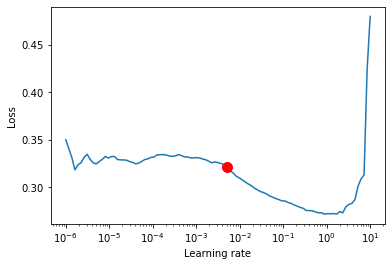

<ipython-input-335-a92b5627800b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [335]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [489]:
class GatedResidualNetwork2(GatedResidualNetwork):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        dropout: float = 0.1,
        context_size: int = None,
        residual: bool = False,
    ):
        super().__init__(input_size, hidden_size, output_size, dropout, context_size, residual)
        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.nn_dropout = nn.Dropout(self.dropout)
        self.residual = residual

        if self.input_size != self.output_size and not self.residual:
            residual_size = self.input_size
        else:
            residual_size = self.output_size

        if self.output_size != residual_size:
            self.resample_norm = ResampleNorm(residual_size, self.output_size)

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.elu = nn.ELU()

        if self.context_size is not None:
            self.context = nn.Linear(self.context_size, self.hidden_size, bias=False)

        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size * 2)
        self.fc3 = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.init_weights()

        self.gate_norm = GateAddNorm(
            input_size=self.hidden_size,
            skip_size=self.output_size,
            hidden_size=self.output_size,
            dropout=self.dropout,
            trainable_add=False,
        )

    def init_weights(self):
        for name, p in self.named_parameters():
            if "bias" in name:
                torch.nn.init.zeros_(p)
            elif "fc1" in name or "fc2" in name or "fc3" in name:
                torch.nn.init.kaiming_normal_(p, a=0, mode="fan_in", nonlinearity="leaky_relu")
            elif "context" in name:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x, context=None, residual=None):
        if residual is None:
            residual = x

        if self.input_size != self.output_size and not self.residual:
            residual = self.resample_norm(residual)

        x = self.fc1(x)
        if context is not None:
            context = self.context(context)
            x = x + context
        x = self.elu(x)
        x = self.fc2(x)
        x = self.elu(x)
        x = self.nn_dropout(x)
        x = self.fc3(x)        
        x = self.gate_norm(x, residual)
        return x

In [490]:
def sm_taylor_softmax(x, dim=1, order=4, margin=0.6):
    fn = torch.ones_like(x)
    fn_margin = torch.ones_like(x)
    factorial = 1.
    for i in range(1, order + 1):
        factorial *= i
        fn_margin += (x - margin).pow(i) / factorial
        fn = fn + x.pow(i) / factorial
    return fn_margin / (fn.sum(dim=dim, keepdims=True) - fn + fn_margin)

class SMTaylorSoftmax(nn.Module):
    def __init__(self, dim=1, order=4, margin=0.6):
        super(SMTaylorSoftmax, self).__init__()
        self.dim = dim
        self.order = order
        self.margin = margin

    def forward(self, x):        
        return sm_taylor_softmax(x, self.dim, self.order, self.margin)

In [491]:
class VariableSelectionNetwork2(VariableSelectionNetwork):
    def __init__(
        self,
        input_sizes: Dict[str, int],
        hidden_size: int,
        input_embedding_flags: Dict[str, bool] = {},
        dropout: float = 0.1,
        context_size: int = None,
        single_variable_grns: Dict[str, GatedResidualNetwork] = {},
        prescalers: Dict[str, nn.Linear] = {},
    ):
        """
        Calcualte weights for ``num_inputs`` variables  which are each of size ``input_size``
        """
        super().__init__(
            input_sizes,
            hidden_size,
            input_embedding_flags,
            dropout,
            context_size,
            single_variable_grns,
            prescalers,
        )
        # self.softmax = nn.LogSoftmax(dim=-1)
        self.softmax = SMTaylorSoftmax(dim=-1)

In [492]:
class ScaledDotProductAttention2(ScaledDotProductAttention):
    def __init__(self, dropout: float = None, scale: bool = True):
        super().__init__(dropout, scale)
        self.softmax = SMTaylorSoftmax(dim=2)

In [493]:
class InterpretableMultiHeadAttention2(InterpretableMultiHeadAttention):
    def __init__(self, n_head: int, d_model: int, dropout: float = 0.0):
        super().__init__(n_head, d_model, dropout)
        self.attention = ScaledDotProductAttention2()

In [494]:
class TemporalFusionTransformer2(TemporalFusionTransformer):
    def __init__(
        self,
        hidden_size: int = 16,
        lstm_layers: int = 1,
        dropout: float = 0.1,
        output_size: Union[int, List[int]] = 7,
        loss: MultiHorizonMetric = None,
        attention_head_size: int = 4,
        max_encoder_length: int = 10,
        static_categoricals: List[str] = [],
        static_reals: List[str] = [],
        time_varying_categoricals_encoder: List[str] = [],
        time_varying_categoricals_decoder: List[str] = [],
        categorical_groups: Dict[str, List[str]] = {},
        time_varying_reals_encoder: List[str] = [],
        time_varying_reals_decoder: List[str] = [],
        x_reals: List[str] = [],
        x_categoricals: List[str] = [],
        hidden_continuous_size: int = 8,
        hidden_continuous_sizes: Dict[str, int] = {},
        embedding_sizes: Dict[str, Tuple[int, int]] = {},
        embedding_paddings: List[str] = [],
        embedding_labels: Dict[str, np.ndarray] = {},
        learning_rate: float = 1e-3,
        log_interval: Union[int, float] = -1,
        log_val_interval: Union[int, float] = None,
        log_gradient_flow: bool = False,
        reduce_on_plateau_patience: int = 1000,
        monotone_constaints: Dict[str, int] = {},
        share_single_variable_networks: bool = False,
        logging_metrics: nn.ModuleList = None,
        **kwargs,
    ):
        super().__init__(
            hidden_size,
            lstm_layers,
            dropout,
            output_size,
            loss,
            attention_head_size,
            max_encoder_length,
            static_categoricals,
            static_reals,
            time_varying_categoricals_encoder,
            time_varying_categoricals_decoder,
            categorical_groups,
            time_varying_reals_encoder,
            time_varying_reals_decoder,
            x_reals,
            x_categoricals,
            hidden_continuous_size,
            hidden_continuous_sizes,
            embedding_sizes,
            embedding_paddings,
            embedding_labels,
            learning_rate,
            log_interval,
            log_val_interval,
            log_gradient_flow,
            reduce_on_plateau_patience,
            monotone_constaints,
            share_single_variable_networks,
            logging_metrics,
            **kwargs,
        )
        # variable selection
        # variable selection for static variables
        static_input_sizes = {name: self.hparams.embedding_sizes[name][1] for name in self.hparams.static_categoricals}
        static_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.static_reals
            }
        )
        self.static_variable_selection = VariableSelectionNetwork2(
            input_sizes=static_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.static_categoricals},
            dropout=self.hparams.dropout,
            prescalers=self.prescalers,
        )

        # variable selection for encoder and decoder
        encoder_input_sizes = {
            name: self.hparams.embedding_sizes[name][1] for name in self.hparams.time_varying_categoricals_encoder
        }
        encoder_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.time_varying_reals_encoder
            }
        )

        decoder_input_sizes = {
            name: self.hparams.embedding_sizes[name][1] for name in self.hparams.time_varying_categoricals_decoder
        }
        decoder_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.time_varying_reals_decoder
            }
        )

        # create single variable grns that are shared across decoder and encoder
        if self.hparams.share_single_variable_networks:
            self.shared_single_variable_grns = nn.ModuleDict()
            for name, input_size in encoder_input_sizes.items():
                self.shared_single_variable_grns[name] = GatedResidualNetwork2(
                    input_size,
                    min(input_size, self.hparams.hidden_size),
                    self.hparams.hidden_size,
                    self.hparams.dropout,
                )
            for name, input_size in decoder_input_sizes.items():
                if name not in self.shared_single_variable_grns:
                    self.shared_single_variable_grns[name] = GatedResidualNetwork2(
                        input_size,
                        min(input_size, self.hparams.hidden_size),
                        self.hparams.hidden_size,
                        self.hparams.dropout,
                    )

        self.encoder_variable_selection = VariableSelectionNetwork2(
            input_sizes=encoder_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.time_varying_categoricals_encoder},
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
            prescalers=self.prescalers,
            single_variable_grns={}
            if not self.hparams.share_single_variable_networks
            else self.shared_single_variable_grns,
        )

        self.decoder_variable_selection = VariableSelectionNetwork2(
            input_sizes=decoder_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.time_varying_categoricals_decoder},
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
            prescalers=self.prescalers,
            single_variable_grns={}
            if not self.hparams.share_single_variable_networks
            else self.shared_single_variable_grns,
        )
        
         # static encoders
        # for variable selection
        self.static_context_variable_selection = GatedResidualNetwork2(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for hidden state of the lstm
        self.static_context_initial_hidden_lstm = GatedResidualNetwork2(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for cell state of the lstm
        self.static_context_initial_cell_lstm = GatedResidualNetwork2(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )
        
        # for post lstm static enrichment
        self.static_context_enrichment = GatedResidualNetwork2(
            self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.dropout
        )
        
         # static enrichment and processing past LSTM
        self.static_enrichment = GatedResidualNetwork2(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
        )        
        
        self.multihead_attn = InterpretableMultiHeadAttention2(
            d_model=self.hparams.hidden_size, n_head=self.hparams.attention_head_size, dropout=self.hparams.dropout
        )
        
        self.pos_wise_ff = GatedResidualNetwork2(
            self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.hidden_size, dropout=self.hparams.dropout
        )        

In [495]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=1,
    dropout=0.3,
    hidden_continuous_size=160,
    output_size=3,
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    log_interval=0,
    reduce_on_plateau_patience=10,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 2372.1k


In [496]:
# fit network
trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 2.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 423 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 317 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm 

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [352]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [472]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
print((actuals - predictions).abs().mean())
print(QuantileLoss([0.5]).loss(predictions.T, actuals).mean())
print(QuantileLoss([0.9]).loss(predictions.T, actuals).mean())

tensor(0.3878)
tensor(0.2437)
tensor(0.1528)


In [354]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

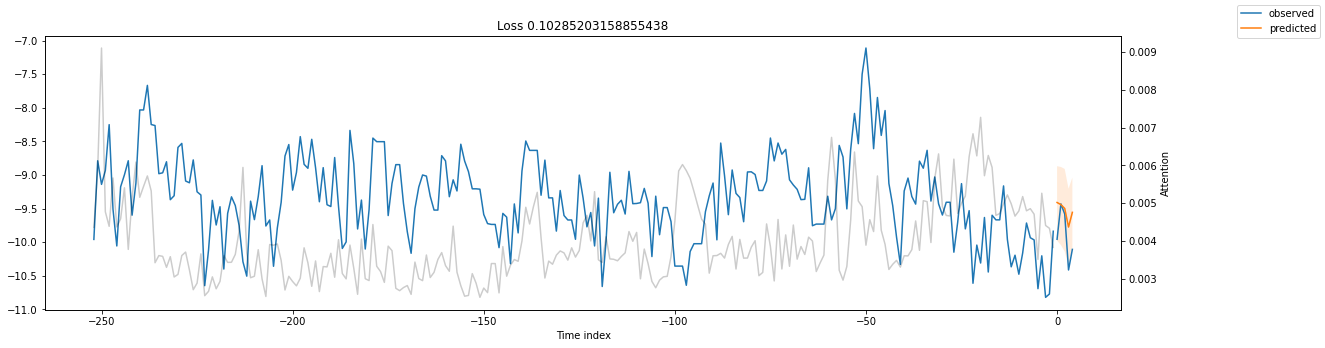

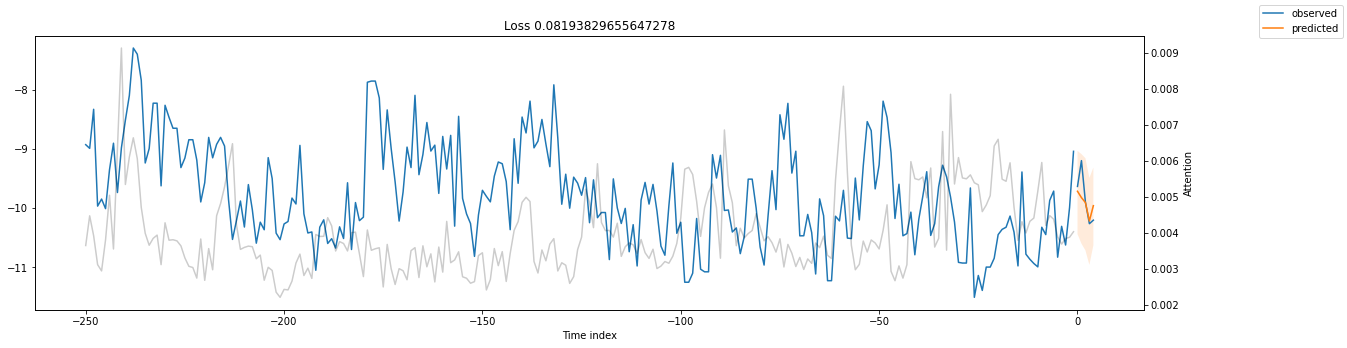

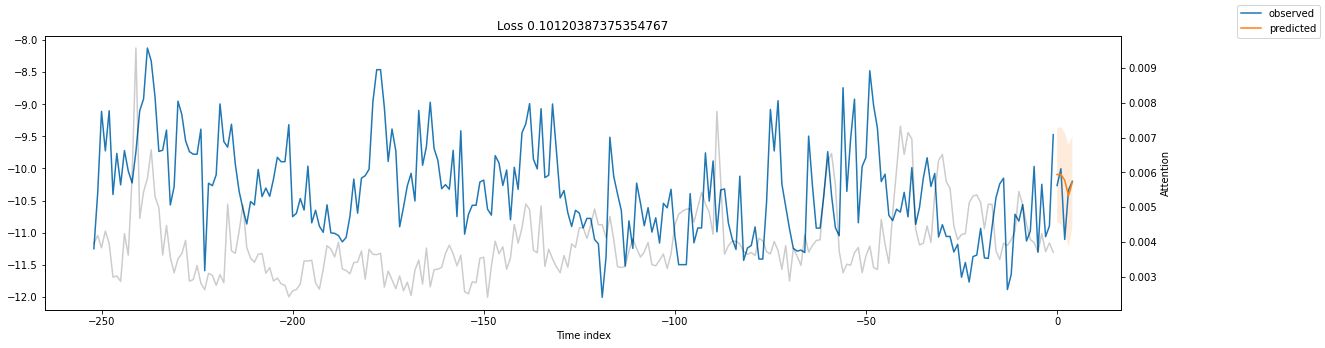

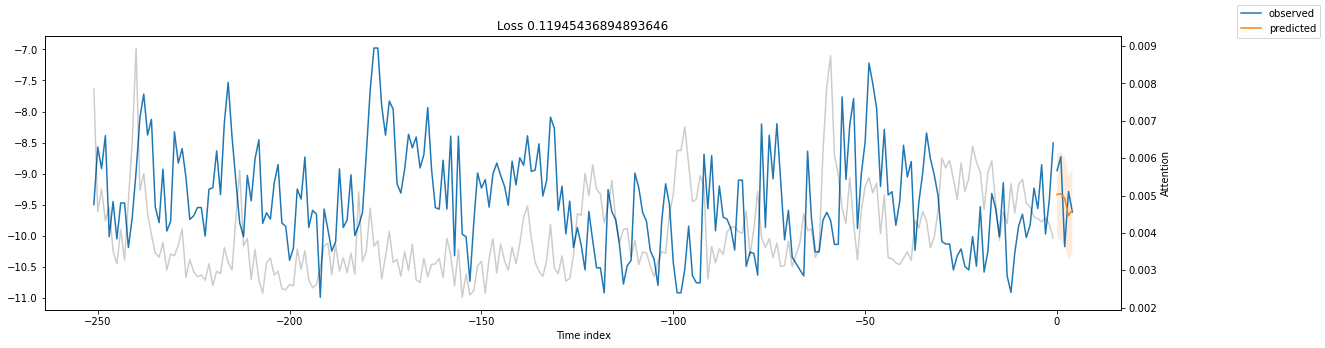

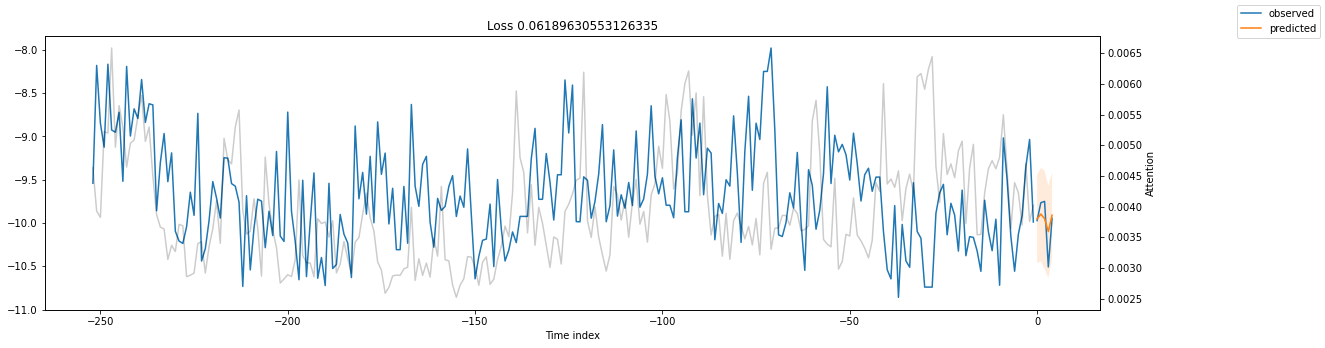

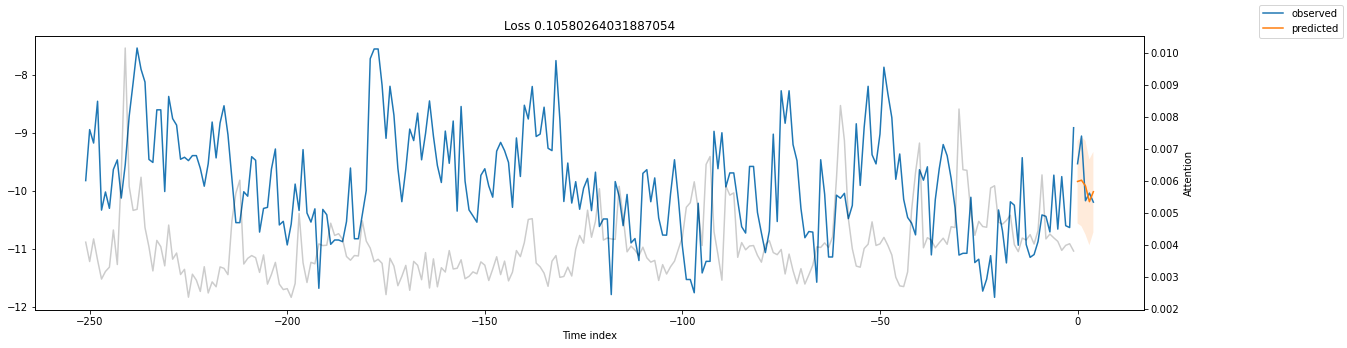

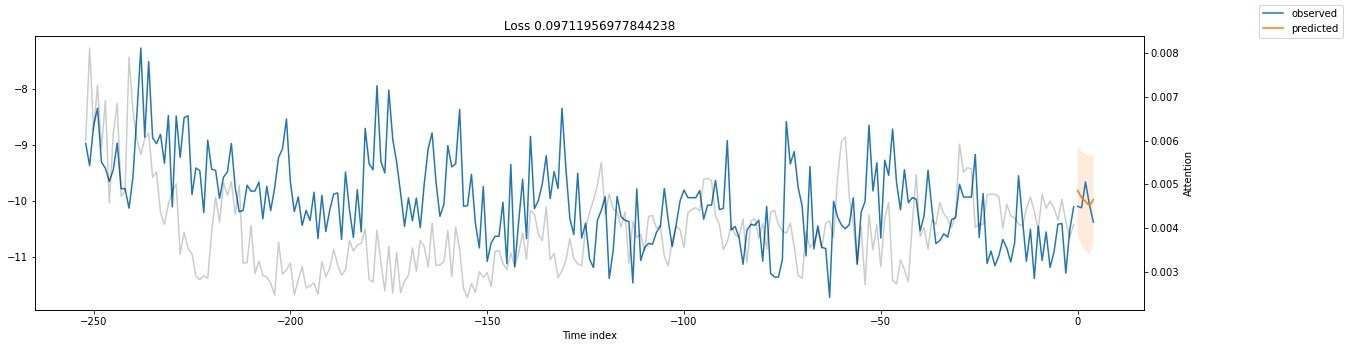

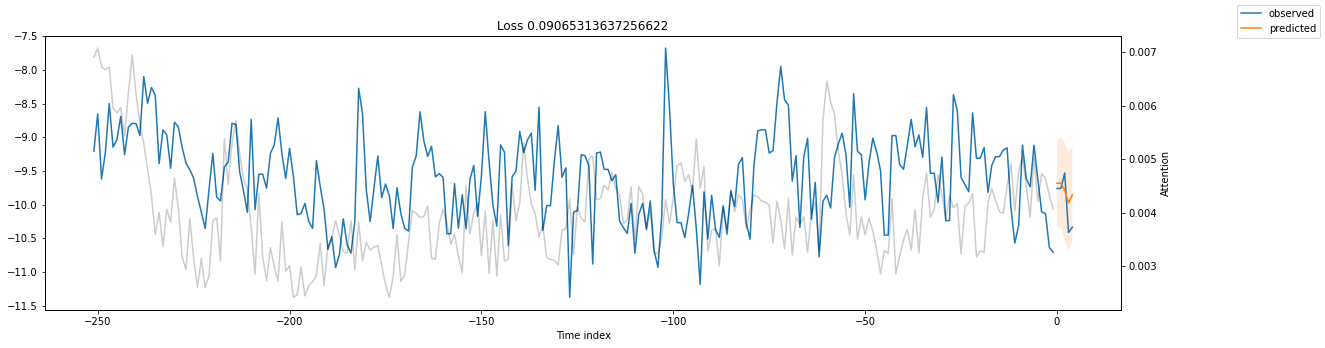

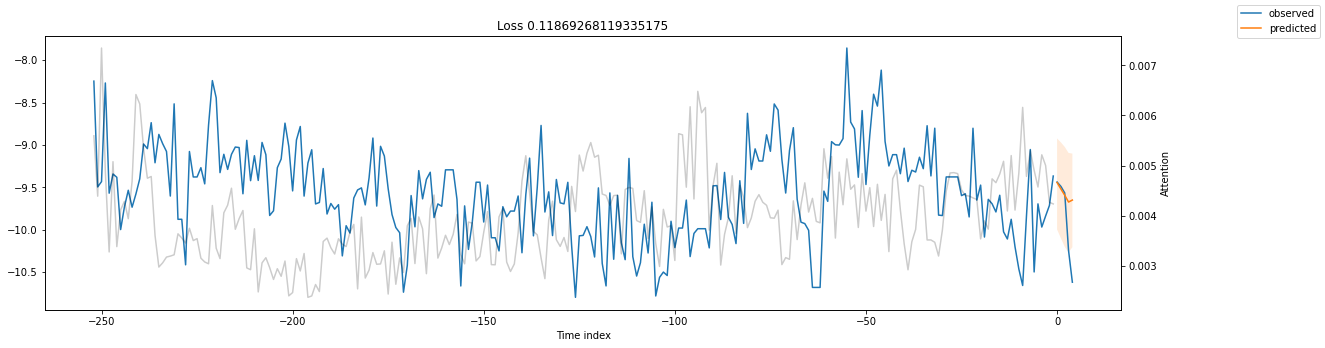

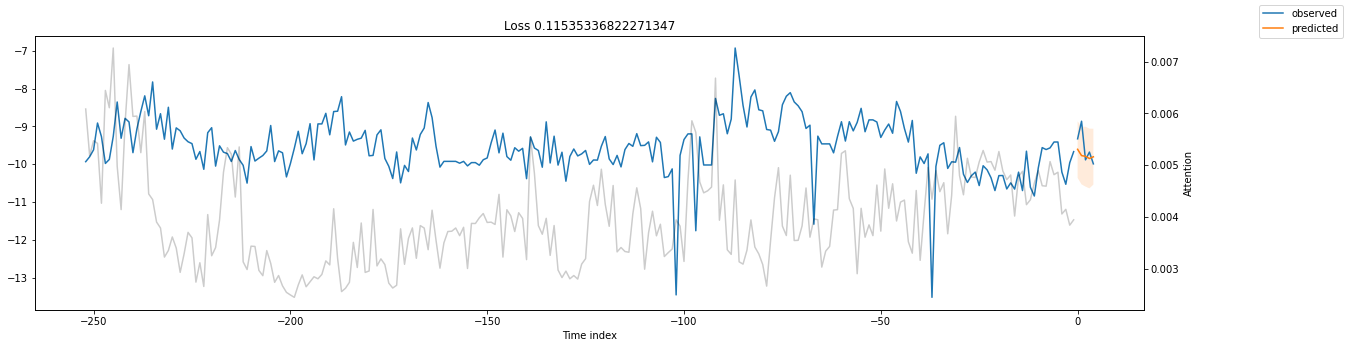

In [355]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True).set_size_inches(20, 5);

In [136]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(160, 200),
    hidden_continuous_size_range=(160, 200),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.01, 0.1),
    dropout_range=(0.3, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study2.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-05-30 04:58:27,187] A new study created in memory with name: no-name-f28fc70a-cf4e-436d-bbb3-10c342d7e8f4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwarg

[I 2021-05-30 05:18:52,571] Trial 7 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:19:15,985] Trial 8 pr

[I 2021-05-30 05:25:28,243] Trial 16 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:25:51,812] Trial 17 

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:29:53,033] Trial 25 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pac

[I 2021-05-30 05:33:12,076] Trial 33 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:33:34,097] Trial 34 

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:38:15,797] Trial 42 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pac

[I 2021-05-30 05:53:54,616] Trial 50 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:54:16,912] Trial 51 

[I 2021-05-30 05:57:47,025] Trial 59 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 05:58:09,324] Trial 60 

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:01:42,397] Trial 68 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pac

[I 2021-05-30 06:05:12,783] Trial 76 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:05:35,611] Trial 77 

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:09:35,839] Trial 85 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pac

[I 2021-05-30 06:18:40,713] Trial 93 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:19:02,978] Trial 94

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:31:58,659] Trial 102 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:36:05,777] Trial 110 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pa

[I 2021-05-30 06:40:46,221] Trial 118 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:41:08,064] Trial 11

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:45:40,706] Trial 127 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pa

[I 2021-05-30 06:49:48,488] Trial 135 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:50:44,978] Trial 13

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:54:52,805] Trial 144 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pa

[I 2021-05-30 06:58:56,142] Trial 152 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 06:59:18,527] Trial 15

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 07:03:25,850] Trial 161 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pa

[I 2021-05-30 07:08:28,448] Trial 169 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 07:08:51,115] Trial 17

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 07:15:12,533] Trial 178 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pa

[I 2021-05-30 07:18:35,608] Trial 186 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 07:18:57,984] Trial 18

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[I 2021-05-30 07:23:04,773] Trial 195 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-pa

{'gradient_clip_val': 0.03897613341500713, 'hidden_size': 180, 'dropout': 0.3, 'hidden_continuous_size': 172, 'attention_head_size': 3, 'learning_rate': 0.025791196930354403}


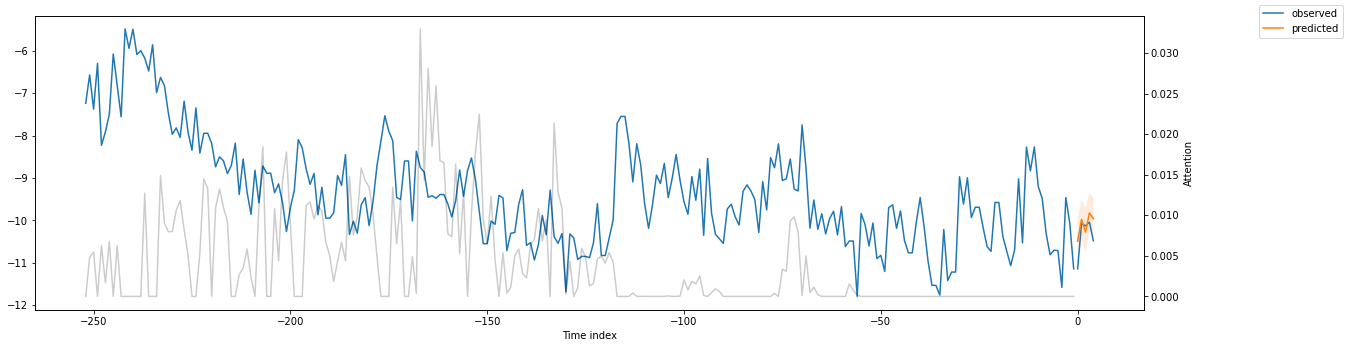

In [144]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.Symbol == ".SPX") & (x.time_idx_first_prediction == 5510)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0).set_size_inches(20, 5);

In [428]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer2 = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft2 = TemporalFusionTransformer2.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=1,
    dropout=0.3,
    hidden_continuous_size=160,
    output_size=3,
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    log_interval=0,
    reduce_on_plateau_patience=10,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 2161.4k


In [429]:
# fit network
trainer2.fit(tft2, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                             | Params
-----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                     | 0     
1  | logging_metrics                    | ModuleList                       | 0     
2  | input_embeddings                   | MultiEmbedding                   | 1.3 K 
3  | prescalers                         | ModuleDict                       | 1.9 K 
4  | static_variable_selection          | VariableSelectionNetwork2        | 313 K 
5  | encoder_variable_selection         | VariableSelectionNetwork2        | 317 K 
6  | decoder_variable_selection         | VariableSelectionNetwork2        | 212 K 
7  | static_context_variable_selection  | GatedResidualNetwork2            | 180 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork2            | 180 K 
9  | static_context_initial

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [430]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path2 = trainer2.checkpoint_callback.best_model_path
best_tft2 = TemporalFusionTransformer2.load_from_checkpoint(best_model_path2)

In [471]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft2.predict(val_dataloader)
print((actuals - predictions).abs().mean())
print(QuantileLoss([0.5]).loss(predictions.T, actuals).mean())
print(QuantileLoss([0.9]).loss(predictions.T, actuals).mean())

tensor(0.4326)
tensor(0.2554)
tensor(0.1933)


In [546]:
def exp_1(x):
    return np.sin(x/4)

def exp_2(x):
    return np.sin(x/8)

def exp_3(x):
    y = np.sin(x/4)
    return  y + 0.1 * np.random.sample()

In [535]:
def create_dataframes(start, size, function):
    base = np.arange(start, start + size, 1.0)
    target = np.vectorize(function)(base)
    return pd.DataFrame(
        dict(
            base=base,
            target=target,
            group=np.full(size, 0),
            time_idx=np.arange(0, size, 1),
        )
    )
TRAINING_SIZE = 1000
VALIDATION_SIZE = 100
MAX_PREDICTION_LENGTH = 5
batch_size = 16
max_encoder_length = MAX_PREDICTION_LENGTH * 10
training_cutoff = data["time_idx"].max() - MAX_PREDICTION_LENGTH

In [536]:
data = create_dataframes(0, TRAINING_SIZE, exp_1)
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    time_varying_known_reals=["base"],
    time_varying_unknown_reals=["target"],
)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=5,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=3,
    )
trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 176   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 424   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 176   
7  | static_context_variable_selection  | GatedResidualNetwork            | 130   
8  | static_context_initial_hidden_lstm | GatedR

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


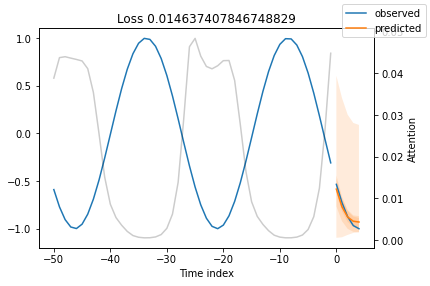

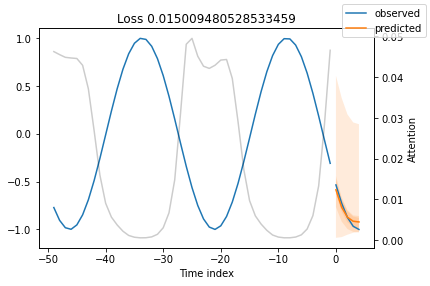

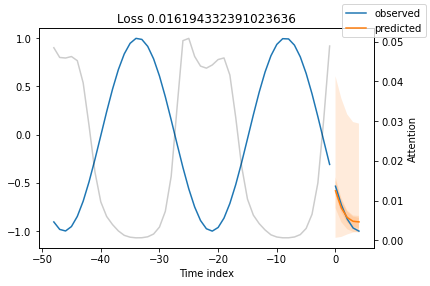

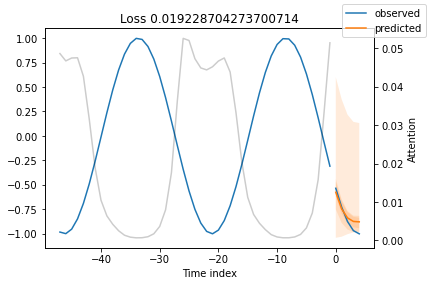

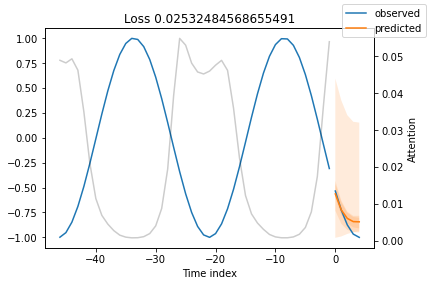

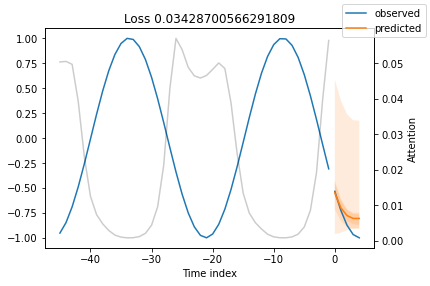

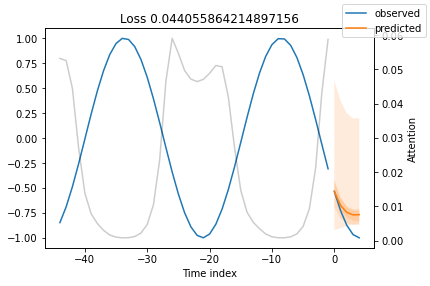

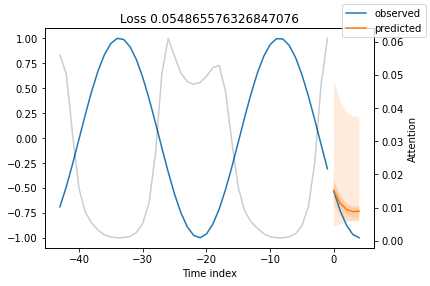

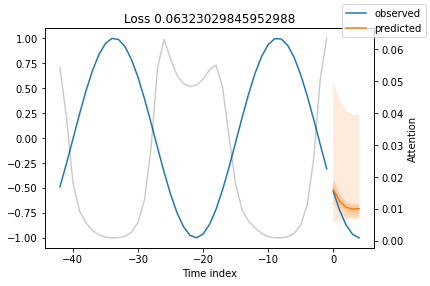

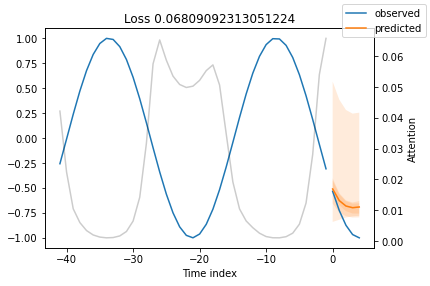

In [537]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [539]:
data = create_dataframes(0, TRAINING_SIZE, exp_2)
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    time_varying_known_reals=["base"],
    time_varying_unknown_reals=["target"],
)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=5,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=3,
    )
trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 176   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 424   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 176   
7  | static_context_variable_selection  | GatedResidualNetwork            | 130   
8  | static_context_initial_hidden_lstm | GatedR

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


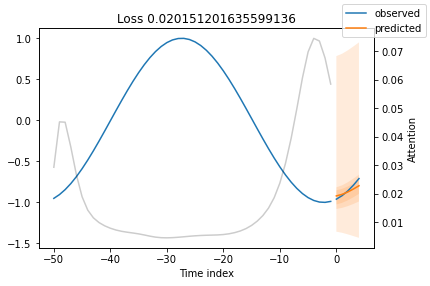

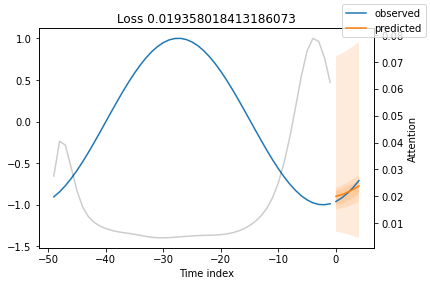

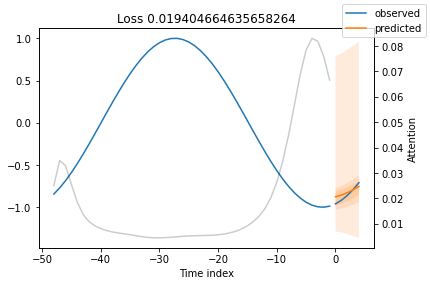

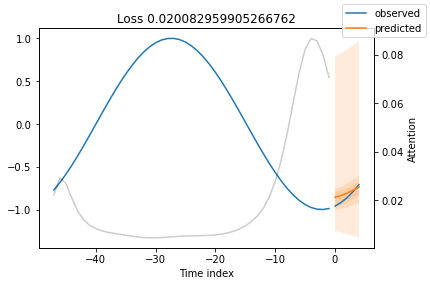

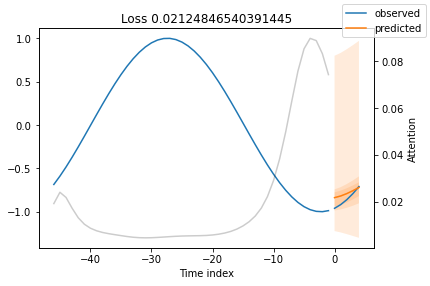

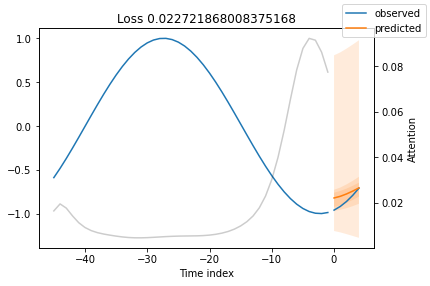

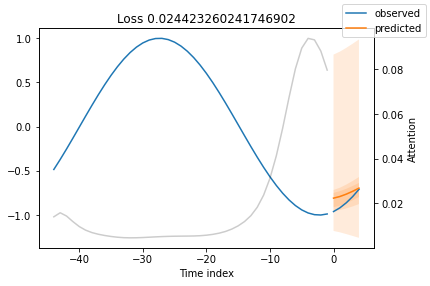

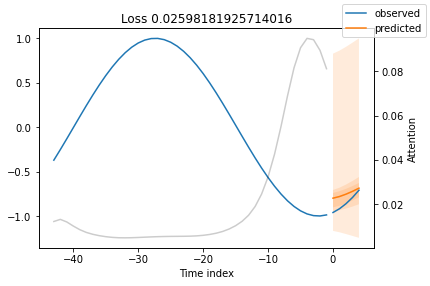

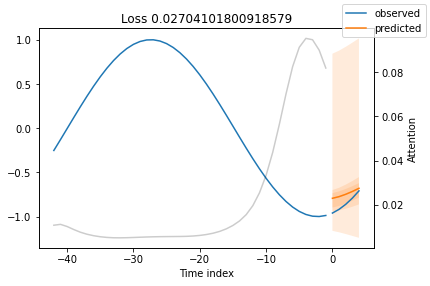

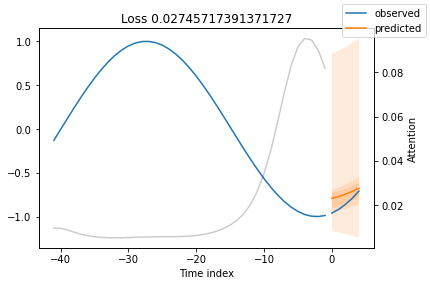

In [540]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [547]:
data = create_dataframes(0, TRAINING_SIZE, exp_3)
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    time_varying_known_reals=["base"],
    time_varying_unknown_reals=["target"],
)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=5,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=3,
    )
trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 176   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 424   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 176   
7  | static_context_variable_selection  | GatedResidualNetwork            | 130   
8  | static_context_initial_hidden_lstm | GatedR

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


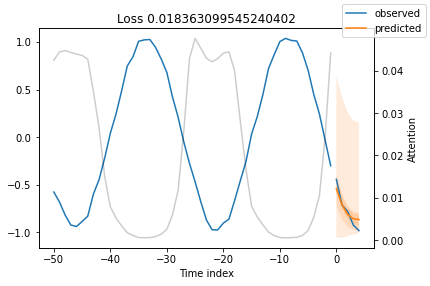

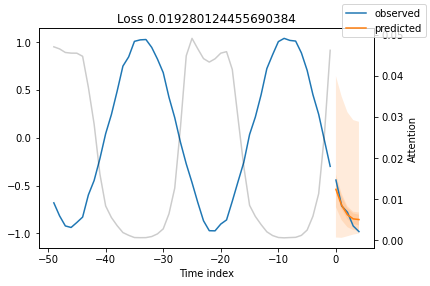

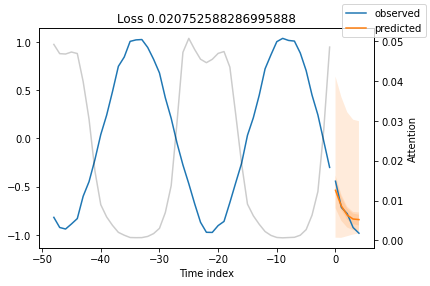

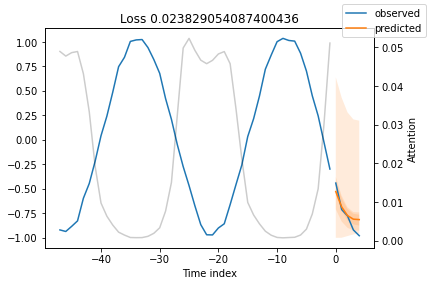

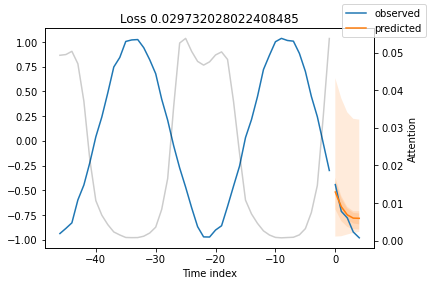

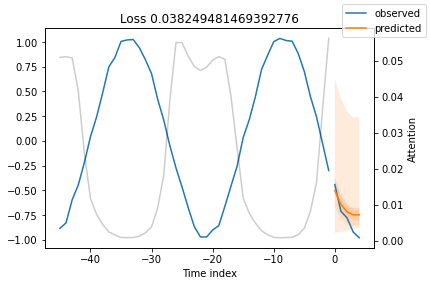

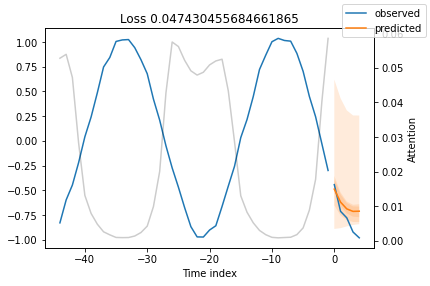

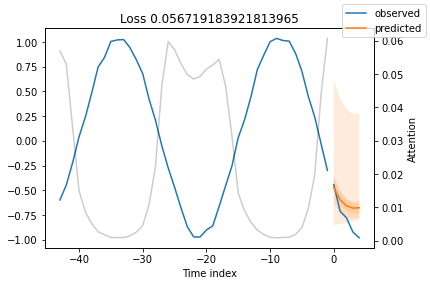

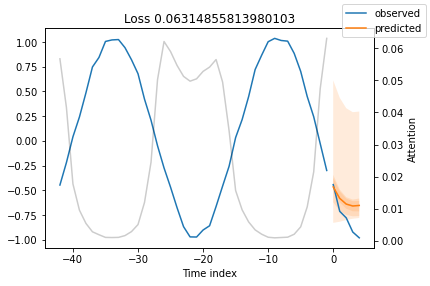

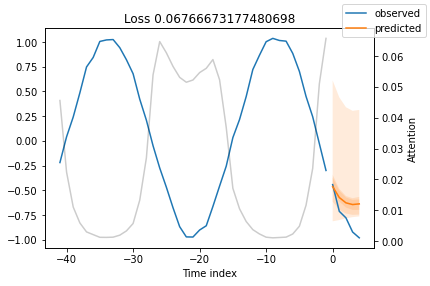

In [548]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)